# Classification Project

In [55]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [56]:
df=pd.read_csv('/Users/afsoon/Documents/Data/DataScienceRoadmap/spam_sms/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [57]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df.columns=['label','Text']
df['label_enc'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Exploratory Data Analysis

<AxesSubplot:xlabel='label_enc', ylabel='count'>

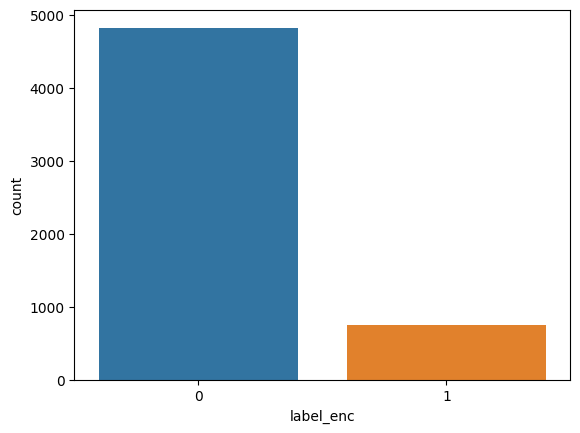

In [58]:
sns.countplot(x=df['label_enc'])

In [59]:
#Since I want to use embeddings in deep learning model, I don't need to balance the data

In [60]:
#Finding average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df.Text])/len(df.Text))
avg_words_len

15

In [61]:
# Finding Total number of unique words in corpus
total_words=[]
for sentence in df.Text:
    for word in sentence.split():
        if word not in total_words:
            total_words.append(word)
            total_words_len=len(total_words)

print(total_words_len)

15585


# Baseline Model Development

In [62]:
# Splitting data for Training and testing
X=df['Text']
y=df['label_enc']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [63]:
tfidf_vec=TfidfVectorizer()
tfidf_vec.fit(X_train)
X_train_vec=tfidf_vec.transform(X_train)
X_test_vec=tfidf_vec.transform(X_test)

In [64]:
baseline_model=MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

# Baseline Model Evaluation

In [65]:
accuracy_score(baseline_model.predict(X_test_vec),y_test)

0.9623318385650225

In [66]:
print(classification_report(baseline_model.predict(X_test_vec),y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1007
           1       0.72      1.00      0.84       108

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



<AxesSubplot:>

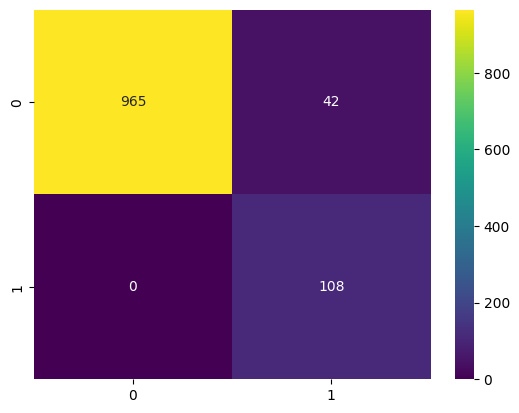

In [67]:
sns.heatmap(confusion_matrix(baseline_model.predict(X_test_vec),y_test),annot=True, fmt='d', cmap='viridis')

# Model 1: Creating custom Text vectorization and embedding layers

In [68]:
#Vectorizing the text 
text_vec = TextVectorization(
    max_tokens=total_words_len,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len)
# Adapting the text vectorization layer to the X_train
text_vec.adapt(X_train)

In [69]:
X_train_processed = text_vec(X_train)
X_test_processed = text_vec(X_test)
X_train_processed

<tf.Tensor: shape=(4457, 15), dtype=int64, numpy=
array([[  40,   24,    9, ...,   11,   55,   19],
       [ 807,   15, 3167, ..., 1892, 2919, 1979],
       [ 110,   88, 1491, ...,    0,    0,    0],
       ...,
       [2075, 2008,  252, ...,    0,    0,    0],
       [ 773, 1739, 1083, ...,    0,    0,    0],
       [   9,  147,   23, ...,    0,    0,    0]])>

In [70]:
#Testing the text_vec
sample_sentence= 'This is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [71]:
#Ctreating embedding layer to vectorize the text
embedding_layer=layers.Embedding(input_dim=total_words_len, output_dim=128,
                               embeddings_initializer='uniform')

In [72]:
#Creating Functional API model
input_layer = layers.Input(shape=(1,), dtype=tf.string) 
vec_layer = text_vec(input_layer) 
embedding_layer_model = embedding_layer(vec_layer) 
x = layers.GlobalAveragePooling1D()(embedding_layer_model) 
x = layers.Flatten()(x) 
x = layers.Dense(32, activation='relu')(x) 
output_layer = layers.Dense(1, activation='sigmoid')(x) 
model1 = keras.Model(input_layer, output_layer)

In [73]:
#Print the model summary
model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,994,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,999,041 (7.63 MB)

 Trainable params: 1,999,041 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
#Compiling the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
#Training the model
history1=model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8441 - loss: 0.3998 - val_accuracy: 0.9641 - val_loss: 0.1660
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9806 - loss: 0.1047 - val_accuracy: 0.9758 - val_loss: 0.0913
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9903 - loss: 0.0398 - val_accuracy: 0.9776 - val_loss: 0.0877
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9950 - loss: 0.0199 - val_accuracy: 0.9785 - val_loss: 0.0859
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0103 - val_accuracy: 0.9803 - val_loss: 0.0822


In [76]:
history1.history

{'accuracy': [0.8947722911834717,
  0.9791339635848999,
  0.9896791577339172,
  0.9955126643180847,
  0.9984294176101685],
 'loss': [0.2839627265930176,
  0.0865827202796936,
  0.03547446429729462,
  0.019314007833600044,
  0.010649950243532658],
 'val_accuracy': [0.9641255736351013,
  0.9757847785949707,
  0.9775784611701965,
  0.9784753322601318,
  0.9802690744400024],
 'val_loss': [0.1659618318080902,
  0.0913013145327568,
  0.08771204203367233,
  0.08585721254348755,
  0.08217533677816391]}

<AxesSubplot:>

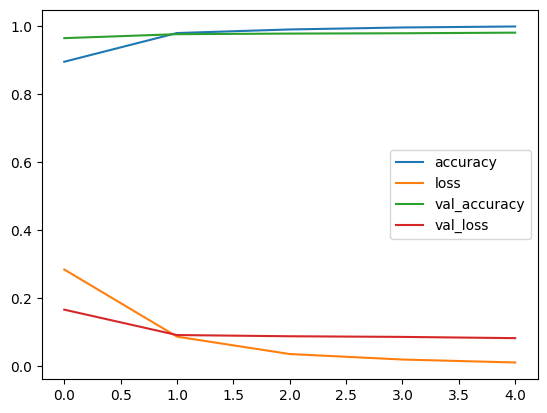

In [77]:
pd.DataFrame(history1.history).plot()

In [78]:
#Creating helper functions for compiling, fitting, and evaluating the model performance

def compile_model(model):
    ''' 
    simply compile the model with adam optimzer 
    '''
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    ''' 
    fit the model with given epochs, train  
    and test data 
    '''
    history=model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test), 
                      epochs=epochs)
    return history

def evaluate_model(model, X, y): 
    ''' 
    evaluate the model and returns accuracy,  
    precision, recall and f1-score  
    '''
    y_preds = np.round(model.predict(X)) 
    accuracy = accuracy_score(y, y_preds) 
    precision = precision_score(y, y_preds) 
    recall = recall_score(y, y_preds) 
    f1 = f1_score(y, y_preds) 
  
    model_results_dict = {'accuracy': accuracy, 
                          'precision': precision, 
                          'recall': recall, 
                          'f1-score': f1} 
  
    return model_results_dict

# Model 2: Bidirectional LSTM

In [79]:
#Creating Functional API model which is Bidirectional LSTM
input_layer=layers.Input(shape=(1,), dtype=tf.string)
vec_layer=text_vec(input_layer)
embedding_layer_model=embedding_layer(vec_layer)
bi_lstm=layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm=layers.LSTM(64)(bi_lstm)
flatten=layers.Flatten()(lstm)
dropout=layers.Dropout(.1)(flatten)
x=layers.Dense(32, activation='relu')(dropout)
output_layer=layers.Dense(1, activation='sigmoid')(x)
model2=keras.Model(input_layer, output_layer)

In [80]:
#Compiling and fitting the model by helper functions
compile_model(model2)
history2=fit_model(model2, epochs=5, X_train=X_train, y_train=y_train, 
              X_test=X_test, y_test=y_test)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9549 - loss: 0.1632 - val_accuracy: 0.9767 - val_loss: 0.1058
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9974 - loss: 0.0122 - val_accuracy: 0.9812 - val_loss: 0.1139
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9821 - val_loss: 0.1263
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9794 - val_loss: 0.0977
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9794 - val_loss: 0.1137


# Model 3: Transfer Learning with USE Encoder

In [81]:
import tensorflow_hub as hub 

In [82]:
#Creating universal-sentence-encoder layer (USE converts text into high-dimensional vectors)
use_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                           trainable=False, 
                           input_shape=[], 
                           dtype=tf.string, 
                           name='USE')

In [86]:
#Creating model with Sequential API 
model3 = keras.Sequential() 
#model3.add(use_layer)
model3.add(layers.Lambda(lambda x: use_layer(x))) 
model3.add(layers.Dropout(0.2)) 
model3.add(layers.Dense(64, activation=keras.activations.relu)) 
model3.add(layers.Dense(1, activation=keras.activations.sigmoid))

In [98]:
# Convert the pandas Series to a numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Reshape the array to have a single dimension
X_train_reshaped = np.squeeze(X_train_np)
X_test_reshaped = np.squeeze(X_test_np)

# Verify the shape
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(4457,)
(1115,)


In [95]:
compile_model(model3) 
history3 = fit_model(model3, epochs=5, X_train=X_train_reshaped, y_train=y_train, 
              X_test=X_test_reshaped, y_test=y_test)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9772 - loss: 0.0833 - val_accuracy: 0.9767 - val_loss: 0.0657
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9878 - loss: 0.0477 - val_accuracy: 0.9794 - val_loss: 0.0573
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9867 - loss: 0.0404 - val_accuracy: 0.9821 - val_loss: 0.0540
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9873 - loss: 0.0434 - val_accuracy: 0.9821 - val_loss: 0.0507
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9899 - loss: 0.0305 - val_accuracy: 0.9839 - val_loss: 0.0490


# Analyzing Model Performance

In [100]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test) 
model1_results = evaluate_model(model1, X_test, y_test) 
model2_results = evaluate_model(model2, X_test, y_test) 
model3_results = evaluate_model(model3, X_test_reshaped, y_test) 
  
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results, 
                             'Custom-Vec-Embedding Model':model1_results, 
                             'Bidirectional-LSTM Model':model2_results, 
                             'USE-Transfer learning Model':model3_results}).transpose() 
  
total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.977578,0.956204,0.873333,0.912892
Bidirectional-LSTM Model,0.979372,0.944056,0.900000,0.921502
USE-Transfer learning Model,0.983857,0.952055,0.926667,0.939189


<AxesSubplot:>

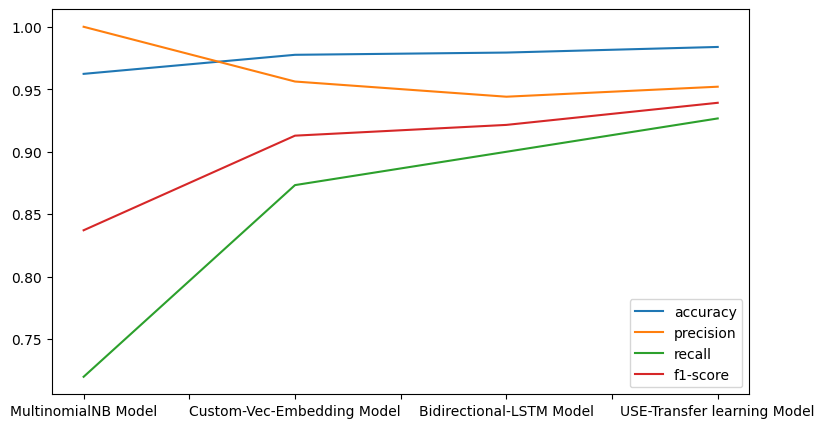

In [116]:
total_results.plot(figsize=(9,5))

In [117]:
#All four models deliver excellent results. (All of them have greater than 96 percent accuracy)

#We have an unbalanced dataset so Accuracy cannot be an appropriate metric in certain situations

#False negative and false positive are significant in this problem. 
#Precision and recall are the metrics that allow us the ability to calculate them

#f1-score is the harmonic mean of precision and recall. Thus, we can get both with a single shot

#USE-Transfer learning model gives the best accuracy and f1-score.